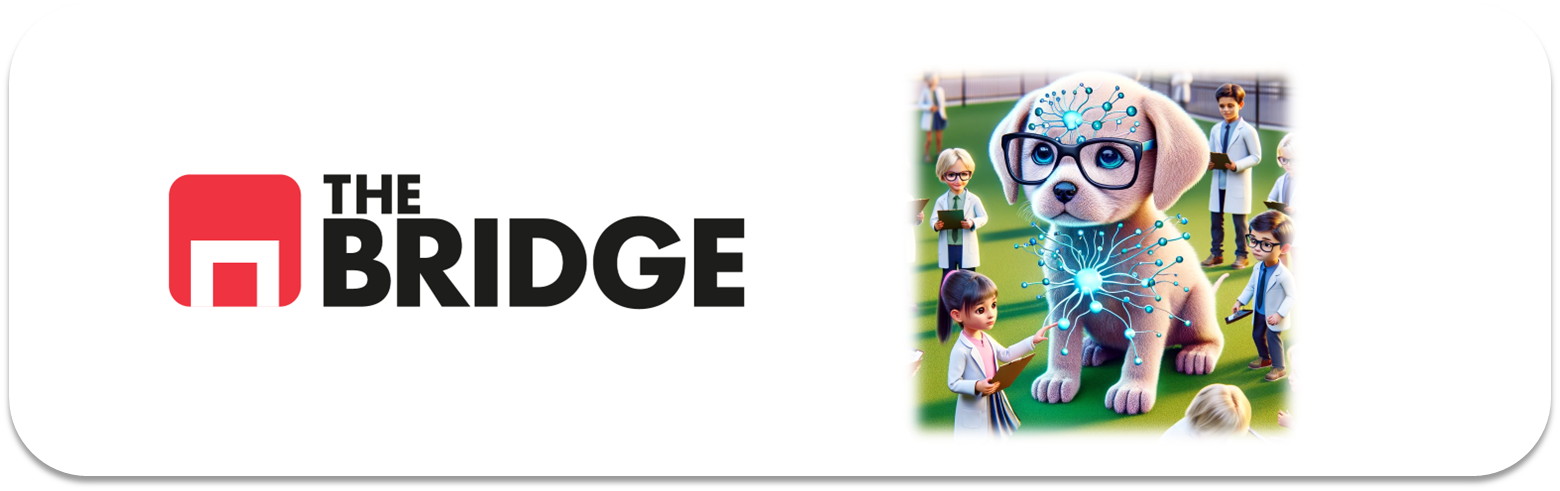

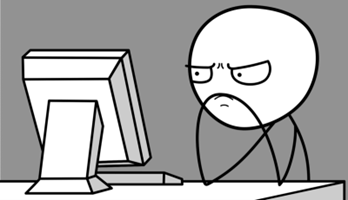

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [34]:
# Cargar el dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\Python Scripts\air_pollution_new_city_2.csv', sep='|')

# Echar un vistazo a los datos
print(df.head())

# Decidir el target
target = 'pm2.5'  # La concentración de PM2.5 es el objetivo a predecir

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir
0  25  2019      1    2     0  129.0   -16  -4.0  1020.0   SE  1.79   0   0
1  26  2019      1    2     1  148.0   -15  -4.0  1020.0   SE  2.68   0   0
2  27  2019      1    2     2  159.0   -11  -5.0  1021.0   SE  3.57   0   0
3  28  2019      1    2     3  181.0    -7  -5.0  1022.0   SE  5.36   1   0
4  29  2019      1    2     4  138.0    -7  -5.0  1022.0   SE  6.25   2   0


### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [35]:
# Convertir las columnas de fecha a datetime y crear un índice
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_indexed = df.set_index('date')

# Deshacerse de las columnas no informativas
df_indexed = df_indexed.drop(columns=['No', 'year', 'month', 'day', 'hour'])

# Renombrar columnas para que sean más expresivas
df_indexed.columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

In [41]:
# Cargar el dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\Python Scripts\air_pollution_new_city_2.csv', sep='|')

# Convertir las columnas de fecha a datetime y crear un índice
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_indexed = df.set_index('date')

# Deshacerse de las columnas no informativas
df_indexed = df_indexed.drop(columns=['No', 'year', 'month', 'day', 'hour'])

# Renombrar columnas para que sean más expresivas
df_indexed.columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

# Verificar las columnas del DataFrame
print("Columnas en df_indexed:", df_indexed.columns)

# Verificar si la columna 'cbwd' existe
if 'cbwd' in df_indexed.columns:
    print("La columna 'cbwd' está presente.")
else:
    print("La columna 'cbwd' no se encuentra en el DataFrame.")

Columnas en df_indexed: Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')
La columna 'cbwd' está presente.


In [42]:
# Codificar la dirección del viento con one-hot encoding
if 'cbwd' in df_indexed.columns:
    encoder = OneHotEncoder(sparse_output=False)
    cbwd_encoded = encoder.fit_transform(df_indexed[['cbwd']])
    cbwd_df = pd.DataFrame(cbwd_encoded, columns=encoder.get_feature_names_out(['cbwd']))
    
    # Concatenar el DataFrame original con el one-hot encoding
    df_indexed = pd.concat([df_indexed, cbwd_df], axis=1)
    
    # Eliminar la columna original de dirección del viento si ya no es necesaria
    df_indexed = df_indexed.drop(columns=['cbwd'], errors='ignore')
else:
    print("La columna 'cbwd' no se encuentra en el DataFrame.")

### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [9]:
print(df_indexed.index)
print(type(df_indexed.index))

DatetimeIndex(['2019-01-02 00:00:00', '2019-01-02 01:00:00',
               '2019-01-02 02:00:00', '2019-01-02 03:00:00',
               '2019-01-02 04:00:00', '2019-01-02 05:00:00',
               '2019-01-02 06:00:00', '2019-01-02 07:00:00',
               '2019-01-02 08:00:00', '2019-01-02 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=43800, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [10]:
# Convertir las columnas de fecha a datetime y crear un índice
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_indexed = df.set_index('date')

In [11]:
print(df_indexed.index.is_monotonic_increasing)  # Debe ser True
print(df_indexed.index.is_unique)  # Debe ser True

False
True


In [12]:
# Ordenar el índice
df_indexed = df_indexed.sort_index()

In [13]:
# Eliminar duplicados
df_indexed = df_indexed[~df_indexed.index.duplicated(keep='first')]

In [14]:
print(df_indexed.index.is_monotonic_increasing)  # Debe ser True
print(df_indexed.index.is_unique)  # Debe ser True

True
True


In [15]:
# Filtrar datos de 2019 a 2022
df_train = df_indexed['2019-01-01':'2022-12-31']

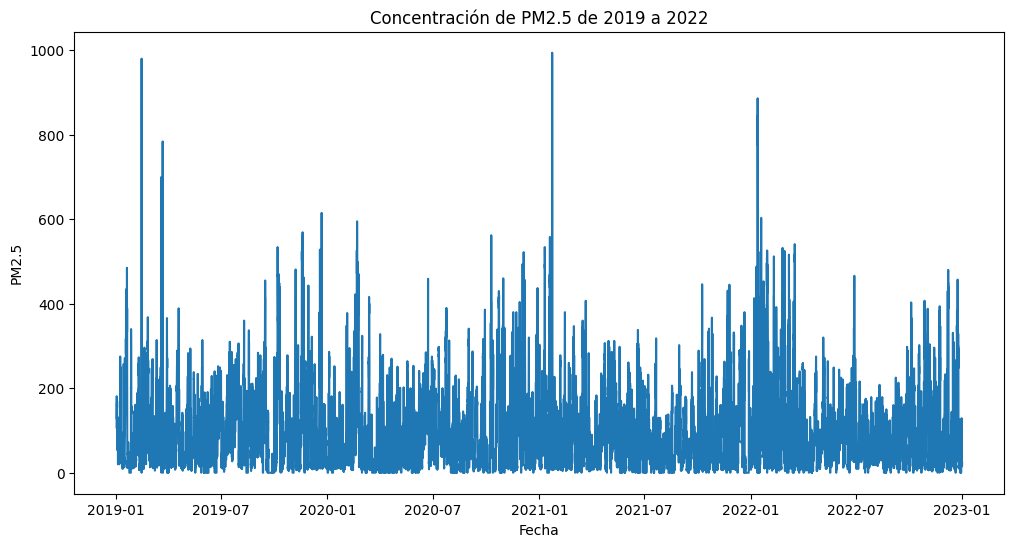

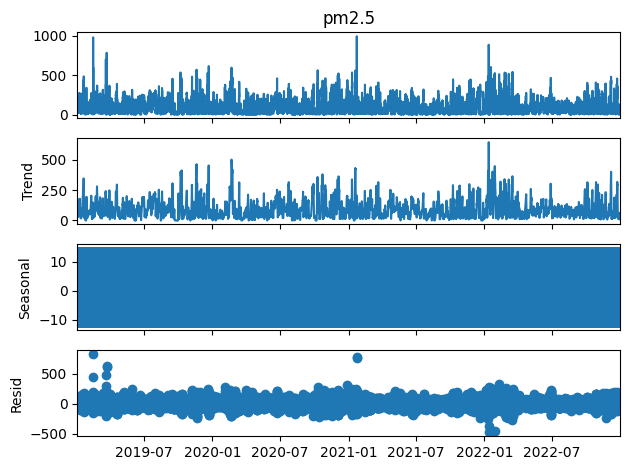

In [16]:
# Graficar el target
plt.figure(figsize=(12, 6))
plt.plot(df_train['pm2.5'])
plt.title('Concentración de PM2.5 de 2019 a 2022')
plt.xlabel('Fecha')
plt.ylabel('PM2.5')
plt.show()

# Descomposición de la serie
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_train['pm2.5'], model='additive')
decomposition.plot()
plt.show()

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

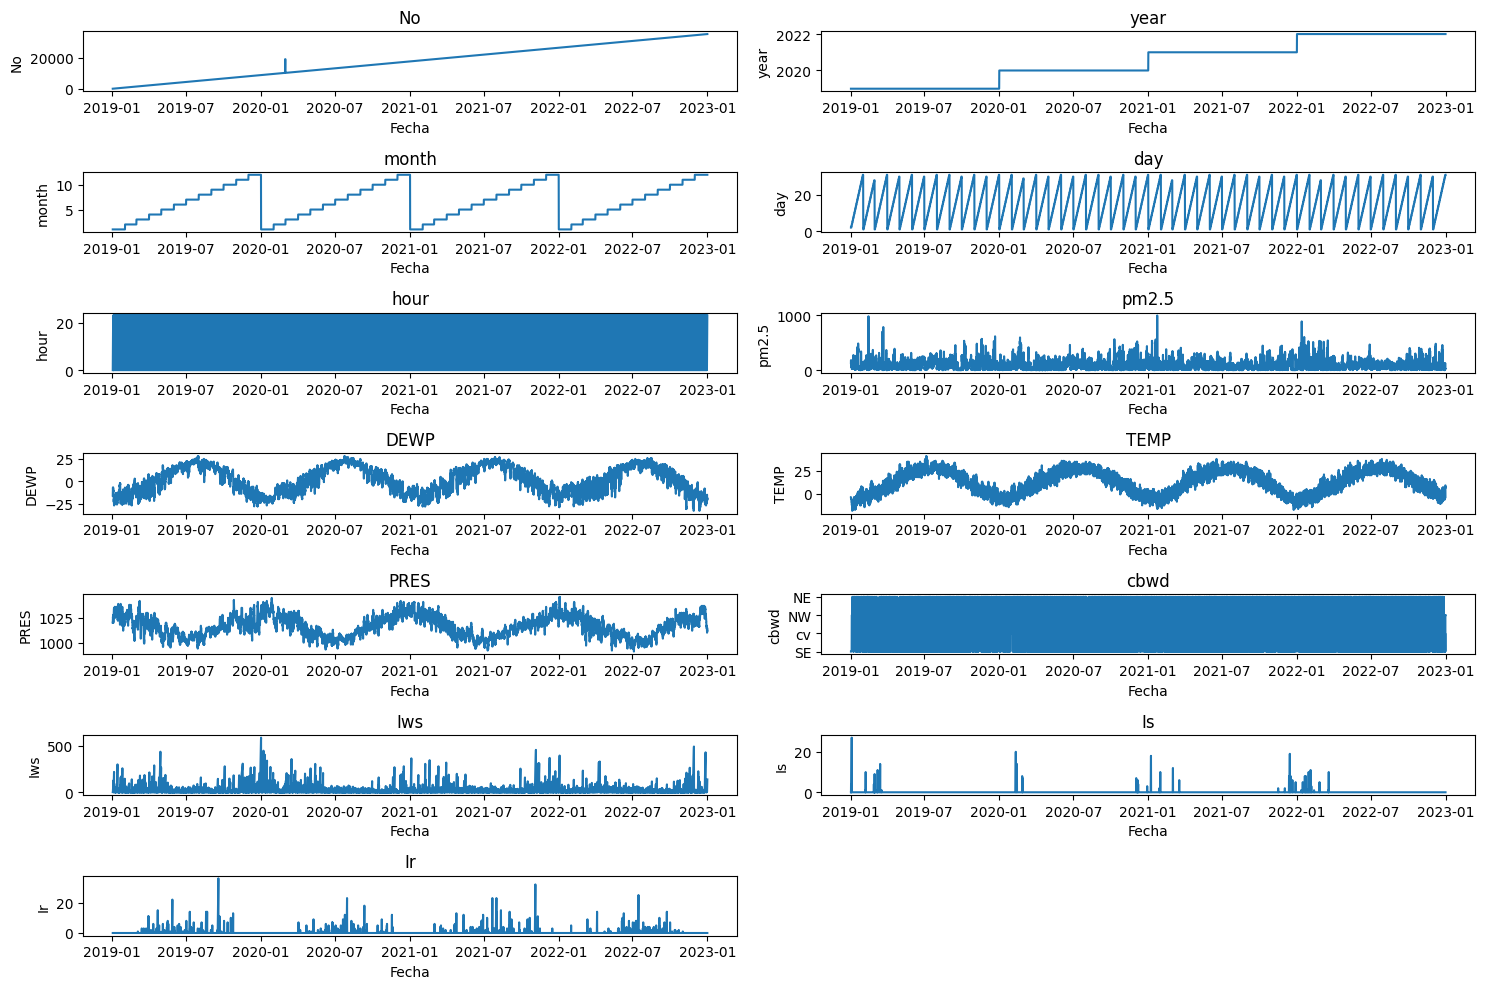

In [17]:
import matplotlib.pyplot as plt

# Crear subplots para cada serie temporal
ncols = 2  # Número de columnas
nrows = (len(df_indexed.columns) + ncols - 1) // ncols  # Calcular el número de filas necesarias
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(df_indexed.columns):
    axs[i].plot(df_train[col])
    axs[i].set_title(col)
    axs[i].set_xlabel('Fecha')
    axs[i].set_ylabel(col)

# Eliminar subgráficas vacías si hay menos columnas que subgráficas
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [43]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Cargar el dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\Python Scripts\air_pollution_new_city_2.csv', sep='|')

# Convertir las columnas de fecha a datetime y crear un índice
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_indexed = df.set_index('date')

# Deshacerse de las columnas no informativas
df_indexed = df_indexed.drop(columns=['No', 'year', 'month', 'day', 'hour'])

# Renombrar columnas para que sean más expresivas
df_indexed.columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

# Codificar la dirección del viento con one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
cbwd_encoded = encoder.fit_transform(df_indexed[['cbwd']])
cbwd_df = pd.DataFrame(cbwd_encoded, columns=encoder.get_feature_names_out(['cbwd']))

# Concatenar el DataFrame original con el one-hot encoding
df_indexed = pd.concat([df_indexed, cbwd_df], axis=1)

# Eliminar la columna original de dirección del viento si ya no es necesaria
df_indexed = df_indexed.drop(columns=['cbwd'], errors='ignore')

# Convertir todas las columnas a np.float32
df_indexed = df_indexed.astype(np.float32)

# Función para crear secuencias
def create_sequences(data, seq_length=48, target_length=12, batch_size=32):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length - target_length + 1):
        seq = data[i:i + seq_length]  # Secuencia de longitud seq_length
        target = data[i + seq_length:i + seq_length + target_length]  # Objetivo de longitud target_length
        sequences.append(seq)
        targets.append(target)
    
    # Convertir a numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    # Verificar las formas antes del reshape
    print("Forma de sequences antes del reshape:", sequences.shape)
    print("Forma de targets antes del reshape:", targets.shape)

    # Dividir en batches
    num_batches = sequences.shape[0] // batch_size
    if num_batches == 0:
        raise ValueError("No hay suficientes secuencias para formar un batch.")

    # Ajustar el número de muestras para que sea múltiplo del batch_size
    sequences = sequences[:num_batches * batch_size]
    targets = targets[:num_batches * batch_size]

    # Nuevo reshape sin errores de dimensiones
    sequences = sequences.reshape(num_batches, batch_size, seq_length, -1)
    targets = targets.reshape(num_batches, batch_size, target_length, -1)

    return sequences, targets

# Crear las secuencias y targets
X, y = create_sequences(df_indexed.values)

# Verificar las formas de los datasets
print("Shape of input sequences:", X.shape)
print("Shape of target sequences:", y.shape)


Forma de sequences antes del reshape: (87541, 48, 11)
Forma de targets antes del reshape: (87541, 12, 11)
Shape of input sequences: (2735, 32, 48, 11)
Shape of target sequences: (2735, 32, 12, 11)


### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#  1 Cargar el dataset
df = pd.read_csv(r'C:\Users\hp\Desktop\Python Scripts\air_pollution_new_city_2.csv', sep='|')

#  2 Convertir fechas a datetime (asegurándonos de que se convierta correctamente)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

#  3 Establecer 'date' como índice y asegurarnos de que se ordene cronológicamente
df.set_index('date', inplace=True)
df.sort_index(inplace=True)  #  Importante para evitar problemas en el filtrado

#  4 Verificar que el índice sea datetime
print(" Tipo de índice:", type(df.index))  
print(" Primeras fechas en el índice:\n", df.index[:5])  # 🔍 Verifica los primeros valores del índice

#  5-Eliminar columnas irrelevantes
df.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

#  6 Renombrar columnas para mayor claridad
df.columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

#  7 Verificar que las fechas de filtrado existen antes de intentar acceder
min_date, max_date = df.index.min(), df.index.max()
print(f" Rango de fechas disponibles: {min_date} → {max_date}")

#  8 Filtrar los datos por periodo
try:
    train_data = df.loc['2020-01-01':'2023-09-30']
    val_data = df.loc['2023-10-01':'2023-10-31']
    test_data = df.loc['2023-11-01':'2023-11-30']
except KeyError as e:
    print(" Error al filtrar por fechas. Asegúrate de que las fechas existen en el índice.")
    raise e  # Lanza el error para ver detalles

#  9️⃣ Imprimir tamaño de los conjuntos
print(f" Train data: {train_data.shape}")
print(f" Validation data: {val_data.shape}")
print(f" Test data: {test_data.shape}")



 Tipo de índice: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
 Primeras fechas en el índice:
 DatetimeIndex(['2019-01-02 00:00:00', '2019-01-02 01:00:00',
               '2019-01-02 02:00:00', '2019-01-02 03:00:00',
               '2019-01-02 04:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)
 Rango de fechas disponibles: 2019-01-02 00:00:00 → 2023-12-31 23:00:00
 Train data: (32856, 8)
 Validation data: (744, 8)
 Test data: (720, 8)


### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 🔹 Simulación de datos (esto se reemplaza con tu dataset real)
np.random.seed(42)
timesteps = 50  # Número de pasos de tiempo en cada secuencia
features = 1  # Solo una característica
samples = 1000  # Número de muestras

# Generamos datos simulados de una serie temporal
data = np.sin(np.linspace(0, 100, samples)).reshape(-1, 1)

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 🔹 Preparar los datos para la red recurrente
X, y = [], []
for i in range(len(data_scaled) - timesteps):
    X.append(data_scaled[i:i + timesteps])
    y.append(data_scaled[i + timesteps])

X, y = np.array(X), np.array(y)

# 🔹 División en conjunto de entrenamiento y prueba
split = int(len(X) * 0.8)  # 80% entrenamiento, 20% prueba
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 🔹 Construcción del modelo con SimpleRNN
model = Sequential([
    SimpleRNN(32, activation="relu", return_sequences=False, input_shape=(timesteps, features)),
    Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# 🔹 Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 🔹 Evaluación del modelo
y_pred = model.predict(X_test)

# 🔹 Transformar predicciones de nuevo a unidades originales
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

# 🔹 Cálculo de métricas en unidades originales
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1899 - mae: 0.3476 - val_loss: 0.0139 - val_mae: 0.1012
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0101 - mae: 0.0839 - val_loss: 0.0018 - val_mae: 0.0382
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - mae: 0.0314 - val_loss: 3.1935e-04 - val_mae: 0.0146
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6905e-04 - mae: 0.0106 - val_loss: 7.0921e-05 - val_mae: 0.0069
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.1952e-05 - mae: 0.0072 - val_loss: 4.5126e-05 - val_mae: 0.0054
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0875e-05 - mae: 0.0053 - val_loss: 2.4035e-05 - val_mae: 0.0039
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.2415e-05 - mae: 0.0038 - val_loss: 1.7483e-05 - val_mae: 0.0033
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5753e-05 - mae: 0.0031 - val_loss: 1.3448e-05 - val_mae: 0.0029
Epoch 9/20
24/24 ━━━

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [62]:
print(df.columns)

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')


In [65]:
y_pred_scaled = model.predict(X_test)
print(y_pred_scaled.shape)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(190, 1)


In [66]:
print(y_test.shape, y_pred_scaled.shape)


(190, 1) (190, 1)


In [67]:
print(X_train.shape)


(760, 50, 1)


In [69]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5239e-06 - mae: 9.0332e-04 - val_loss: 2.0137e-06 - val_mae: 0.0011
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6423e-06 - mae: 9.8524e-04 - val_loss: 1.6880e-06 - val_mae: 9.8125e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3259e-06 - mae: 8.8181e-04 - val_loss: 2.1632e-06 - val_mae: 0.0011
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6600e-06 - mae: 0.0010 - val_loss: 1.4847e-06 - val_mae: 9.1403e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2735e-06 - mae: 8.6157e-04 - val_loss: 1.7938e-06 - val_mae: 0.0011
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4746e-06 - mae: 9.2684e-04 - val_loss: 1.2693e-06 - val_mae: 8.3007e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1092e-06 - mae: 7.6534e-04 - val_loss: 1.1777e-06 - val_mae: 8.1375e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0905e-06 - mae: 7.8191e-

In [70]:
y_pred_scaled = model.predict(X_test)
print("Forma de y_pred_scaled:", y_pred_scaled.shape)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Forma de y_pred_scaled: (190, 1)


In [71]:
print("Forma de X_test antes de predecir:", X_test.shape)


Forma de X_test antes de predecir: (190, 50, 1)


### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [ ]:



import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1 Cargar los datos
df = pd.read_csv(r'C:\Users\hp\Desktop\Python Scripts\air_pollution_new_city_2.csv', sep='|')

# 2 Eliminar filas con valores nulos antes de convertir fechas
df.dropna(subset=['year', 'month', 'day', 'hour'], inplace=True)

# 3 Convertir las columnas de fecha a datetime y crear un índice
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)
df.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)

# 4 Renombrar columnas para mayor claridad
df.columns = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

# 5 Verificar si "cbwd" es categórica y hacer One-Hot Encoding
if df['cbwd'].dtype == 'object':
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    cbwd_encoded = encoder.fit_transform(df[['cbwd']])
    cbwd_df = pd.DataFrame(cbwd_encoded, columns=encoder.get_feature_names_out(['cbwd']), index=df.index)
    
    df = pd.concat([df.drop(columns=['cbwd']), cbwd_df], axis=1)

# 6 Normalizar los datos (se escala el target por separado)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

features = df.drop(columns=['pm2.5'])  # Variables predictoras
target = df[['pm2.5']]  # Variable objetivo

features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

# 7 Función para crear secuencias
def create_sequences(X, y, seq_length=48):
    sequences, targets = [], []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        targets.append(y[i + seq_length])
    return np.array(sequences), np.array(targets)

# 8 Definir la longitud de la secuencia
seq_length = 48

X_seq, y_seq = create_sequences(features_scaled, target_scaled, seq_length)

# 9 Dividir los datos en entrenamiento y prueba (80% - 20%)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# 9 Construcción del modelo GRU
model = Sequential([
    GRU(32, activation='tanh', return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dense(16, activation='relu'),
    Dense(1)  # Capa de salida para predecir el valor de 'pm2.5'
])

# 10 Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 11 Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 12 Evaluar el modelo
y_pred_scaled = model.predict(X_test)

# Invertir la normalización para obtener valores en la escala original
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Calcular métricas
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 9/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 11/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 12/50
875/875 ━━━━━━━━━━